In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.utils import shuffle
from sklearn import set_config, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, LeaveOneGroupOut, GroupKFold, StratifiedGroupKFold

In [3]:
sns.set_context("talk")
sns.set_theme(style='white')
sns.set_palette('bright')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_main_author = pd.read_csv(r'/content/drive/MyDrive/TAL_classification/data/MAIN_CANON_1000.csv')
df_main_author.set_index("index", inplace = True)
df_main_author = df_main_author.replace(np.nan, 0)

In [6]:
df_main_author.head()

,le,de,un,et,il,avoir,à,lui,être,son,...,arrêté,chair,lueur,glace,colonel,île,énorme,pont,paysan,canon
index,,,,,,,,,,,,,,,,,,,,,
1811_Chateaubriand-François-Rene-de_Oeuvres-completes,0.073227,0.074235,0.025755,0.025387,0.013422,0.017301,0.019712,0.005607,0.013674,0.007144,...,0.000098,0.000037,0.000037,0.000006,0.000000,0.000603,0.000012,0.000197,0.000111,canon
1812_Kock-Paul-de_L-enfant-de-ma-femme,0.062699,0.056479,0.019378,0.022654,0.023758,0.017336,0.021955,0.016471,0.015771,0.020575,...,0.000184,0.000000,0.000000,0.000037,0.004012,0.000000,0.000000,0.000000,0.000221,non_canon
1815_Gay-Sophie_Anatole_Vol-1,0.074455,0.083807,0.022538,0.018506,0.013186,0.017548,0.018176,0.023397,0.012062,0.018407,...,0.000033,0.000000,0.000033,0.000000,0.000000,0.000000,0.000033,0.000000,0.000000,non_canon
1815_Gay-Sophie_Anatole_Vol-2,0.078353,0.088045,0.019131,0.018089,0.013038,0.015721,0.020109,0.022982,0.011428,0.022508,...,0.000063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,0.000000,non_canon
1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge-de-l-Indostan-ou-les-Portugais-au-Malabar_(Tome-2),0.058306,0.054293,0.020645,0.019710,0.027627,0.021772,0.021305,0.020205,0.014102,0.017209,...,0.000165,0.000000,0.000000,0.000027,0.000000,0.000000,0.000000,0.000027,0.000330,non_canon


In [7]:
def get_df_with_authors(df):
    df_res = df.copy()
    list_author = []
    for elem in df_res.index:
        list_author.append(elem.split('_')[1])
    print(len(set(list_author)))
    df_res['auteur'] = list_author
    return df_res

In [8]:
df_main_author = get_df_with_authors(df_main_author)

714


In [9]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    fig, ax = plt.subplots(figsize=(15, 5))

    colors = ['canon' if c < 0 else 'non_canon' for c in coefs[top_coefficients]]
    feature_names = np.array(feature_names)
    zipped = list(zip(feature_names, coefs[top_coefficients], colors))
    df_tmp = pd.DataFrame(zipped, columns=['features', 'coefs', 'colors'])

    sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())

    ax.set_xlabel('Feature name', fontsize = 30)
    ax.set_ylabel('Coefficient score', fontsize = 30)

    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    #plt.title("Best classification coefficients")
    #plt.savefig('../img/coefs_linear_svm_canon_novels.png', format='png', bbox_inches='tight', dpi=400)

    plt.show()



In [10]:
def GKF_canonized(df_main, n_splits=5, probas=False, kernel='rbf'):

    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_PROBAS, ALL_INDEX = [], [] # lists of all test probas and all test index

    pipe = make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=probas, kernel=kernel))#{"canon":10, "non_canon":1}
    gkf = GroupKFold(n_splits)

    for (train_index, test_index) in gkf.split(df_main.drop(['auteur', 'canon'], axis=1), df_main['canon'], df_main['auteur']):
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'canon'], axis=1)
            y_train = train['canon']
            X_test = test.drop(['auteur', 'canon'], axis=1)
            y_test = test['canon']

            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_test)

            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)

            if probas==True:
                probs = pipe.predict_proba(X_test)[:,0]
                ALL_PROBAS.extend(probs)


    _ = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)

    if kernel == 'linear':
        coefs = pipe.named_steps['svc'].coef_
        df_coefs = pd.DataFrame(coefs, columns=X_train.columns)
        #df_coefs.to_csv("../outputs/outputs_SVM_GFK/coefs_novel_scale.csv")
        plot_coefficients(*coefs, X_train.columns, 20)
        return pipe, df_scores, bas, df_coefs

    if probas==True:
        df_results = pd.DataFrame()

        df_results['metadata'] = ALL_GT
        df_results['proba_canon'] = ALL_PROBAS
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]

        return pipe, df_scores, bas, df_results.set_index('index')

    return pipe, df_scores, bas

0.7343020612541749


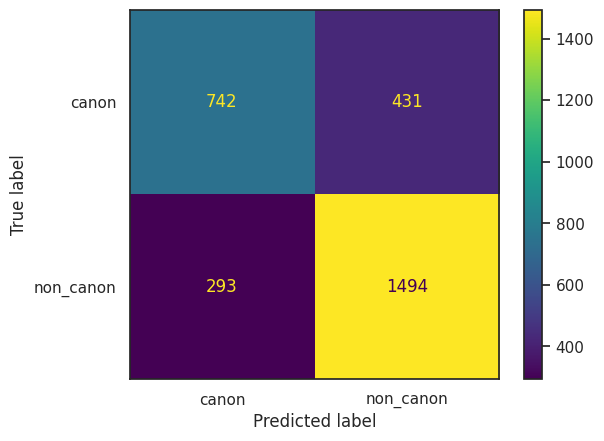

In [11]:
pipe, df_scores, bas, df_results = GKF_canonized(df_main_author, probas=True)

In [ ]:
df_scores

,precision,recall,f1-score,support
canon,0.720038,0.640239,0.677798,1173.000000
non_canon,0.779864,0.836598,0.807235,1787.000000
accuracy,0.758784,0.758784,0.758784,0.758784


In [ ]:
df_results.to_csv('../outputs/outputs_SVM_GFK/output_GKF_canonizer_author_scale.csv', index=True)

In [ ]:
bas

0.740695923146758

In [ ]:
df_final_scores

,precision,recall,f1-score,support
canon,0.720952,0.645354,0.681062,1173.000000
non_canon,0.782199,0.836038,0.808223,1787.000000
accuracy,0.760473,0.760473,0.760473,0.760473


In [ ]:
print(df_final_scores.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
canon     &      0.721 &   0.645 &     0.681 & 1173.000 \\
non\_canon &      0.782 &   0.836 &     0.808 & 1787.000 \\
accuracy  &      0.760 &   0.760 &     0.760 &    0.760 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5221/3649009022.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_final_scores.to_latex(float_format="%.3f"))


In [ ]:
joblib.dump(pipe, 'pipes/pipeline_author_scale.pkl')

['pipes/pipeline_author_scale.pkl']

0.6390019135071854


<ipython-input-16-60a16ae58eb8>:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())


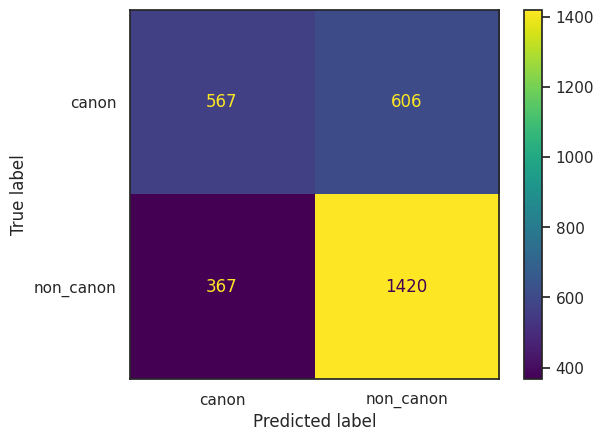

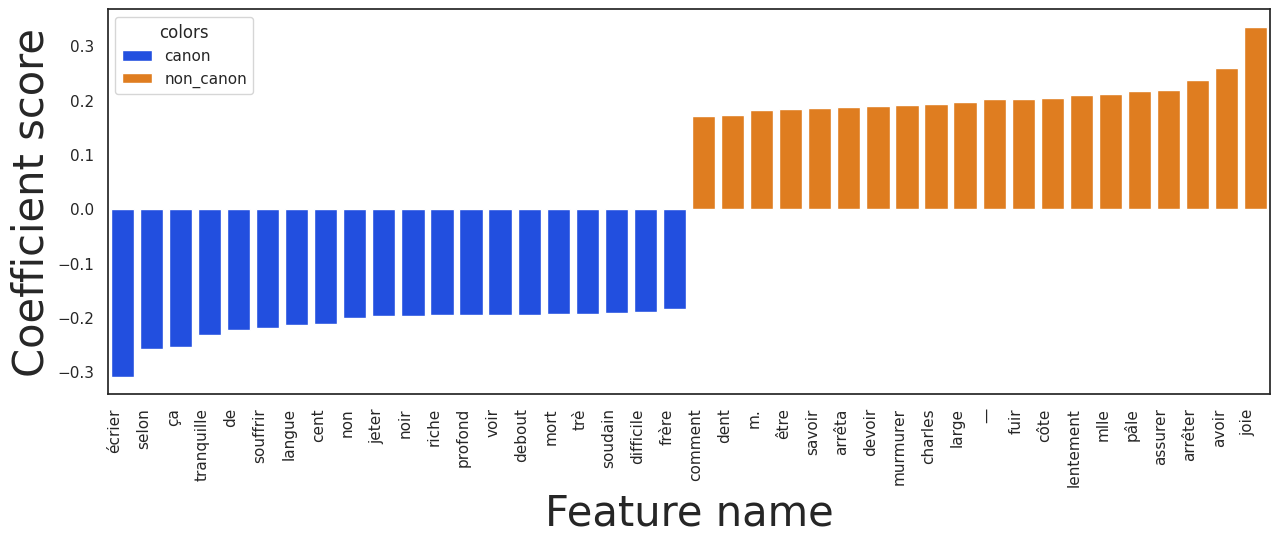

In [ ]:
pipe, df_scores, bas, df_coefs = GKF_canonized(df_main_author, kernel='linear')

In [ ]:
df_coefs.to_csv('../outputs/outputs_SVM_GFK/coefs_author_scale.csv', header=True, index=False)